In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Session Crashed Code**

In [3]:
import os
import numpy as np
from PIL import Image, ImageEnhance
import random
import gc
import matplotlib.pyplot as plt

# Define the color map for classes
color_map = {
    0: (255, 255, 0),  # Background
    1: (199, 252, 0),  # Glacier
    2: (254, 0, 86),   # House_Building
    3: (0, 183, 235),  # Ice
    4: (134, 34, 255), # Land
    5: (255, 255, 0),  # Undefined
    6: (0, 255, 206),  # Vegetation
    7: (255, 128, 0),  # Water
}

def normalize_image(image):
    return image.astype(np.float32) / 255.0

def one_hot_encode_mask(mask, num_classes=8):
    one_hot = np.zeros((mask.shape[0], mask.shape[1], num_classes), dtype=np.float32)
    for class_value in range(num_classes):
        one_hot[mask == class_value, class_value] = 1
    return one_hot

def make_divisible(image, patch_size):
    height, width = image.shape[:2]
    new_height = (height // patch_size) * patch_size
    new_width = (width // patch_size) * patch_size
    return image[:new_height, :new_width]

def create_patches(image, patch_size):
    patches = []
    height, width = image.shape[:2]
    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):
            patch = image[i:i + patch_size, j:j + patch_size]
            if patch.shape[:2] == (patch_size, patch_size):
                patches.append(patch)
    return np.array(patches)

def random_horizontal_flip(image, mask, probability=0.5):
    if random.random() < probability:
        image = np.fliplr(image)
        mask = np.fliplr(mask)
    return image, mask

def random_vertical_flip(image, mask, probability=0.5):
    if random.random() < probability:
        image = np.flipud(image)
        mask = np.flipud(mask)
    return image, mask

def random_rotate(image, mask, angle_range=(-30, 30)):
    angle = random.uniform(angle_range[0], angle_range[1])
    image = Image.fromarray((image * 255).astype(np.uint8))
    mask = Image.fromarray(np.argmax(mask, axis=-1).astype(np.uint8))
    image = image.rotate(angle, resample=Image.BICUBIC)
    mask = mask.rotate(angle, resample=Image.NEAREST)
    return np.array(image) / 255.0, one_hot_encode_mask(np.array(mask))

def random_brightness_contrast(image, brightness_factor=0.2, contrast_factor=0.2):
    enhancer = ImageEnhance.Brightness(Image.fromarray((image * 255).astype(np.uint8)))
    image = enhancer.enhance(1 + random.uniform(-brightness_factor, brightness_factor))
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1 + random.uniform(-contrast_factor, contrast_factor))
    return np.array(image) / 255.0

def apply_augmentation(image, mask):
    image, mask = random_horizontal_flip(image, mask)
    image, mask = random_vertical_flip(image, mask)
    image, mask = random_rotate(image, mask)
    image = random_brightness_contrast(image)
    return image, mask


In [4]:
def process_all_images(image_folder, mask_folder, patch_size):
    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))

    all_image_patches, all_mask_patches = [], []

    for image_file in image_files:
        image_name = os.path.splitext(image_file)[0]
        corresponding_mask = next((mask for mask in mask_files if mask.startswith(image_name)), None)

        if corresponding_mask is None:
            print(f"Skipping {image_file}: no corresponding mask found.")
            continue

        image = np.array(Image.open(os.path.join(image_folder, image_file)).convert("RGB"))
        mask = np.array(Image.open(os.path.join(mask_folder, corresponding_mask)).convert("L"))

        image = normalize_image(image)
        mask = one_hot_encode_mask(mask, num_classes=8)

        image = make_divisible(image, patch_size)
        mask = make_divisible(mask, patch_size)

        image, mask = apply_augmentation(image, mask)

        image_patches = create_patches(image, patch_size)
        mask_patches = create_patches(mask, patch_size)

        all_image_patches.extend(image_patches)
        all_mask_patches.extend(mask_patches)

    return np.array(all_image_patches), np.array(all_mask_patches)


In [5]:
def apply_color_map(mask, color_map):
    class_mask = np.argmax(mask, axis=-1)
    rgb_mask = np.zeros((*class_mask.shape, 3), dtype=np.uint8)
    for class_value, color in color_map.items():
        rgb_mask[class_mask == class_value] = color
    return rgb_mask

def visualize_patches(image_patches, mask_patches, color_map, num_samples=10):
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(min(num_samples, len(image_patches))):
        image, mask = image_patches[i], mask_patches[i]
        colored_mask = apply_color_map(mask, color_map)

        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'Image Patch {i + 1}')

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(colored_mask)
        plt.axis('off')
        plt.title(f'Mask Patch {i + 1}')

    plt.tight_layout()
    plt.show()


Using device: cuda


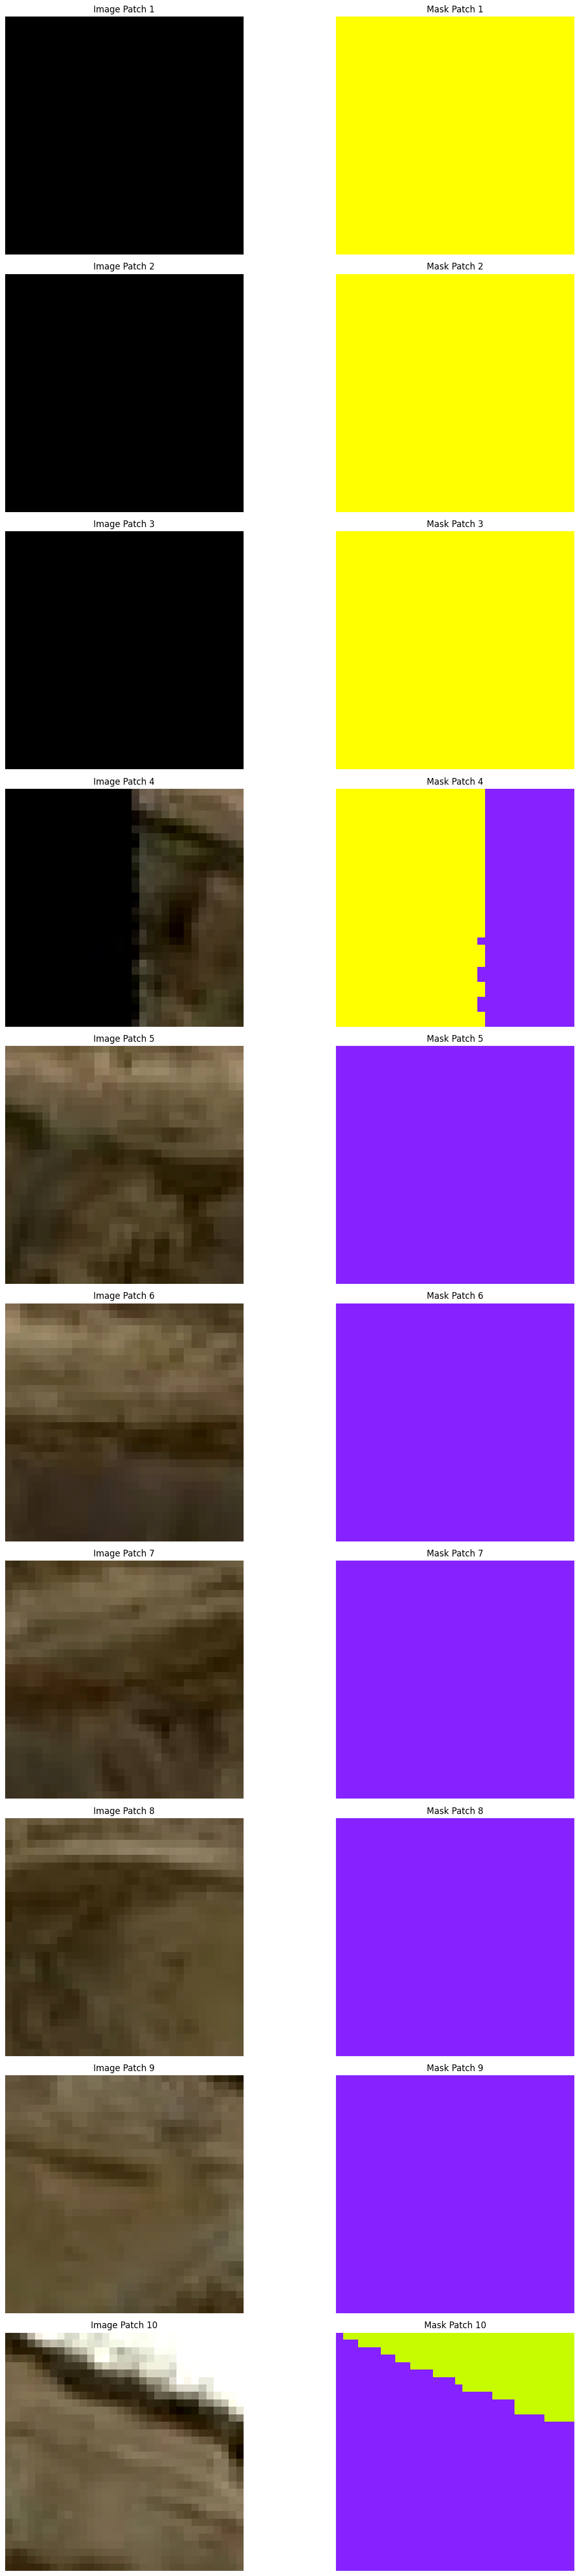

In [6]:
import torch

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

image_folder = '/content/drive/MyDrive/originals'  # Replace with your folder path
mask_folder = '/content/drive/MyDrive/masks'       # Replace with your folder path
patch_size = 32

image_patches, mask_patches = process_all_images(image_folder, mask_folder, patch_size)
visualize_patches(image_patches, mask_patches, color_map, num_samples=10)


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU

In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, Model

def decoder_block(input_tensor, skip_features, num_filters):
    """
    Decoder block for the U-Net model.

    Args:
        input_tensor: Input tensor to the decoder block.
        skip_features: Skip connection features from the encoder.
        num_filters: Number of filters for the convolutional layers.

    Returns:
        Output tensor of the decoder block.
    """
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)
    x = layers.Concatenate()([x, skip_features])
    x = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
    return x

def build_unet_vgg16(input_shape, num_classes):
    # Load VGG16 with pre-trained weights, excluding its top layers
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze VGG16 layers to retain pre-trained weights
    for layer in vgg16.layers:
        layer.trainable = False

    # Encoder blocks from VGG16
    s1 = vgg16.get_layer('block1_conv2').output  # Skip connection 1
    s2 = vgg16.get_layer('block2_conv2').output  # Skip connection 2
    s3 = vgg16.get_layer('block3_conv3').output  # Skip connection 3
    s4 = vgg16.get_layer('block4_conv3').output  # Skip connection 4
    p4 = vgg16.get_layer('block5_conv3').output  # Bridge

    # Decoder blocks
    d1 = decoder_block(p4, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(d4)

    return Model(inputs=vgg16.input, outputs=outputs)

# Model summary
input_shape = (32, 32, 3)
num_classes = 8
model = build_unet_vgg16(input_shape, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 32, 32, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 32, 32, 64)     │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 16, 16, 64)     │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 16, 16, 128)    │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 16, 16, 128)    │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 8, 8, 128)      │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 8, 8, 256)      │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 8, 8, 256)      │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 8, 8, 256)      │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 4, 4, 256)      │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 4, 4, 512)      │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 4, 4, 512)      │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 4, 4, 512)      │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 2, 2, 512)      │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 2, 2, 512)      │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 2, 2, 512)      │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 25,855,112 (98.63 MB)

 Trainable params: 11,140,424 (42.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy', MeanIoU(num_classes=num_classes)]
)

In [10]:
from sklearn.model_selection import train_test_split
import gc

# Ensure that the image data matches the expected input shape for VGG16
# VGG16 expects input shape of (256, 256, 3) for images
image_patches = image_patches.reshape(-1, 32, 32, 3)

# Ensure masks are in the right shape for output layer (num_classes = 8 in your case)
mask_patches = mask_patches.reshape(-1, 32, 32, 8)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(image_patches, mask_patches, test_size=0.2, random_state=42)

# Free up memory
gc.collect()


51673

In [11]:
print(X_train.shape)  # Should output (num_train_samples, 256, 256, 3)
print(X_val.shape)  # Should output (num_val_samples, 256, 256, 3)

(52726, 32, 32, 3)
(13182, 32, 32, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.vgg16 import preprocess_input

# Ensure TensorFlow uses GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Avoid reserving all GPU memory upfront
        print("GPU setup complete. Using:", tf.test.gpu_device_name())
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Training will run on CPU.")

# Apply VGG16-specific preprocessing
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

# Callbacks
checkpoint = ModelCheckpoint(
    'unet_model_epoch_{epoch:02d}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Ensure training on GPU
with tf.device('/GPU:0'):
    # Training the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=8,
        callbacks=[checkpoint, early_stopping]
    )

# Optionally, save the final model after training is complete
model.save('final_vgg_unet_model.keras_1')


Physical devices cannot be modified after being initialized


In [4]:
from tensorflow.keras import backend as K

# Clear session and GPU memory
K.clear_session()


In [15]:
!pip install --upgrade pillow

In [17]:
import PIL
print(PIL.__version__)


11.0.0


In [13]:
!pip install -U Pillow # Update pillow to the latest version
from PIL import Image
# Import Resampling directly from PIL.Image
from PIL.Image import Resampling

In [11]:
!pip install -U Pillow # Update pillow to the latest version
from PIL import Image
from PIL import Image, ImageEnhance #existing line
# Import Resampling directly from PIL.Image
from PIL.Image import Resampling

**Introduce Data Loaders & Augmentation**

In [21]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import Image, ImageEnhance #existing line


# Enable mixed precision training
mixed_precision.set_global_policy('mixed_float16')

def resize_image(image, target_size):
    """Resize the image to the target size using PIL."""
    return np.array(Image.fromarray(image).resize(target_size, Image.Resampling.LANCZOS))


class DataGenerator(Sequence):
    def __init__(self, image_files, mask_files, batch_size, image_folder, mask_folder, patch_size, num_classes=8):
        self.image_files = image_files
        self.mask_files = mask_files
        self.batch_size = batch_size
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_files) // self.batch_size

    def __getitem__(self, index):
        batch_images = self.image_files[index * self.batch_size:(index + 1) * self.batch_size]
        batch_masks = self.mask_files[index * self.batch_size:(index + 1) * self.batch_size]

        images, masks = [], []
        for img_file, mask_file in zip(batch_images, batch_masks):
            # Load and preprocess image
            image = np.array(Image.open(os.path.join(self.image_folder, img_file)).convert("RGB"))
            image = resize_image(image, (self.patch_size, self.patch_size))  # Resize image

            # Load and preprocess mask
            mask = np.array(Image.open(os.path.join(self.mask_folder, mask_file)).convert("L"))
            mask = resize_image(mask, (self.patch_size, self.patch_size))  # Resize mask
            mask = one_hot_encode_mask(mask, num_classes=self.num_classes)

            # Debugging: Check shapes
            assert image.shape == (self.patch_size, self.patch_size, 3), f"Image shape mismatch: {image.shape}"
            assert mask.shape == (self.patch_size, self.patch_size, self.num_classes), f"Mask shape mismatch: {mask.shape}"

            images.append(image)
            masks.append(mask)

        images = np.array(images).astype(np.float32)
        masks = np.array(masks).astype(np.float32)

        return images, masks

    def on_epoch_end(self):
        combined = list(zip(self.image_files, self.mask_files))
        np.random.shuffle(combined)
        self.image_files, self.mask_files = zip(*combined)

def one_hot_encode_mask(mask, num_classes):
    """Convert a grayscale mask to a one-hot encoded format."""
    one_hot = np.zeros((mask.shape[0], mask.shape[1], num_classes), dtype=np.float32)
    for c in range(num_classes):
        one_hot[:, :, c] = (mask == c).astype(np.float32)
    return one_hot

# U-Net Model with VGG16 Encoder
def decoder_block(input_tensor, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)
    x = layers.Concatenate()([x, skip_features])
    x = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
    return x

def build_unet_vgg16(input_shape, num_classes):
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in vgg16.layers:
        layer.trainable = False

    s1 = vgg16.get_layer('block1_conv2').output
    s2 = vgg16.get_layer('block2_conv2').output
    s3 = vgg16.get_layer('block3_conv3').output
    s4 = vgg16.get_layer('block4_conv3').output
    p4 = vgg16.get_layer('block5_conv3').output

    d1 = decoder_block(p4, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(d4)
    return Model(inputs=vgg16.input, outputs=outputs)

# Paths
image_folder = '/content/drive/MyDrive/originals'
mask_folder = '/content/drive/MyDrive/masks'
patch_size = 32

# File Lists
image_files = sorted(os.listdir(image_folder))
mask_files = sorted(os.listdir(mask_folder))

# Train-Test Split
train_images, val_images, train_masks, val_masks = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

# Data Generators
batch_size = 4
train_generator = DataGenerator(train_images, train_masks, batch_size, image_folder, mask_folder, patch_size)
val_generator = DataGenerator(val_images, val_masks, batch_size, image_folder, mask_folder, patch_size)

# Build Model
input_shape = (patch_size, patch_size, 3)
num_classes = 8
model = build_unet_vgg16(input_shape, num_classes)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy', MeanIoU(num_classes=num_classes)]
)

# Callbacks
checkpoint = ModelCheckpoint('unet_model_best.keras', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train Model
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=200,
        callbacks=[checkpoint, early_stopping]
    )

# Save Final Model
model.save('final_unet_model.keras')


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.1200 - loss: 13.8520 - mean_io_u_8: 0.4220 - val_accuracy: 0.1245 - val_loss: 13.7012 - val_mean_io_u_8: 0.4239
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.1228 - loss: 13.8093 - mean_io_u_8: 0.4229 - val_accuracy: 0.1245 - val_loss: 13.7012 - val_mean_io_u_8: 0.4239
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 792ms/step - accuracy: 0.1208 - loss: 13.8448 - mean_io_u_8: 0.4223 - val_accuracy: 0.6853 - val_loss: 5.0390 - val_mean_io_u_8: 0.7185
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 581ms/step - accuracy: 0.6046 - loss: 6.3587 - mean_io_u_8: 0.6642 - val_accuracy: 0.7056 - val_loss: 4.7373 - val_mean_io_u_8: 0.7318
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 604ms/step - accuracy: 0.5684 - loss: 6.9487 - mean_io_u_8: 0.6405 - val_accuracy: 0.7090 - val_loss: 4.6894 - val_mean_io_u_8: 0.7347
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - accuracy: 0.5759 - loss: 6.8350 - mean_io_u_8: 0.6451 - val_accuracy:

In [24]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import Image, ImageEnhance #existing line


# Enable mixed precision training
mixed_precision.set_global_policy('mixed_float16')

def resize_image(image, target_size):
    """Resize the image to the target size using PIL."""
    return np.array(Image.fromarray(image).resize(target_size, Image.Resampling.LANCZOS))


class DataGenerator(Sequence):
    def __init__(self, image_files, mask_files, batch_size, image_folder, mask_folder, patch_size, num_classes=8):
        self.image_files = image_files
        self.mask_files = mask_files
        self.batch_size = batch_size
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_files) // self.batch_size

    def __getitem__(self, index):
        batch_images = self.image_files[index * self.batch_size:(index + 1) * self.batch_size]
        batch_masks = self.mask_files[index * self.batch_size:(index + 1) * self.batch_size]

        images, masks = [], []
        for img_file, mask_file in zip(batch_images, batch_masks):
            # Load and preprocess image
            image = np.array(Image.open(os.path.join(self.image_folder, img_file)).convert("RGB"))
            image = resize_image(image, (self.patch_size, self.patch_size))  # Resize image

            # Load and preprocess mask
            mask = np.array(Image.open(os.path.join(self.mask_folder, mask_file)).convert("L"))
            mask = resize_image(mask, (self.patch_size, self.patch_size))  # Resize mask
            mask = one_hot_encode_mask(mask, num_classes=self.num_classes)

            # Debugging: Check shapes
            assert image.shape == (self.patch_size, self.patch_size, 3), f"Image shape mismatch: {image.shape}"
            assert mask.shape == (self.patch_size, self.patch_size, self.num_classes), f"Mask shape mismatch: {mask.shape}"

            images.append(image)
            masks.append(mask)

        images = np.array(images).astype(np.float32)
        masks = np.array(masks).astype(np.float32)

        return images, masks

    def on_epoch_end(self):
        combined = list(zip(self.image_files, self.mask_files))
        np.random.shuffle(combined)
        self.image_files, self.mask_files = zip(*combined)

def one_hot_encode_mask(mask, num_classes):
    """Convert a grayscale mask to a one-hot encoded format."""
    one_hot = np.zeros((mask.shape[0], mask.shape[1], num_classes), dtype=np.float32)
    for c in range(num_classes):
        one_hot[:, :, c] = (mask == c).astype(np.float32)
    return one_hot

# U-Net Model with VGG16 Encoder
def decoder_block(input_tensor, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)
    x = layers.Concatenate()([x, skip_features])
    x = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
    return x

def build_unet_vgg16(input_shape, num_classes):
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in vgg16.layers:
        layer.trainable = False

    s1 = vgg16.get_layer('block1_conv2').output
    s2 = vgg16.get_layer('block2_conv2').output
    s3 = vgg16.get_layer('block3_conv3').output
    s4 = vgg16.get_layer('block4_conv3').output
    p4 = vgg16.get_layer('block5_conv3').output

    d1 = decoder_block(p4, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(d4)
    return Model(inputs=vgg16.input, outputs=outputs)

# Paths
image_folder = '/content/drive/MyDrive/originals'
mask_folder = '/content/drive/MyDrive/masks'
patch_size = 32

# File Lists
image_files = sorted(os.listdir(image_folder))
mask_files = sorted(os.listdir(mask_folder))

# Train-Test Split
train_images, val_images, train_masks, val_masks = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

# Data Generators
batch_size = 4
train_generator = DataGenerator(train_images, train_masks, batch_size, image_folder, mask_folder, patch_size)
val_generator = DataGenerator(val_images, val_masks, batch_size, image_folder, mask_folder, patch_size)

# Build Model
input_shape = (patch_size, patch_size, 3)
num_classes = 8
model = build_unet_vgg16(input_shape, num_classes)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy', MeanIoU(num_classes=num_classes)]
)

# Callbacks
checkpoint = ModelCheckpoint('unet_model_best.keras', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train Model
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=200,
        callbacks=[checkpoint, early_stopping]
    )

# Save Final Model
model.save('final_unet_model.keras')


Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.0459 - loss: 15.1993 - mean_io_u_9: 0.3970 - val_accuracy: 0.0356 - val_loss: 15.4337 - val_mean_io_u_9: 0.3941
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 0.0432 - loss: 15.2365 - mean_io_u_9: 0.3963 - val_accuracy: 0.0356 - val_loss: 15.4337 - val_mean_io_u_9: 0.3941
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 608ms/step - accuracy: 0.0479 - loss: 15.1506 - mean_io_u_9: 0.3982 - val_accuracy: 0.2092 - val_loss: 12.6078 - val_mean_io_u_9: 0.4554
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4454 - loss: 8.8117 - mean_io_u_9: 0.5717 - val_accuracy: 0.7285 - val_loss: 4.3606 - val_mean_io_u_9: 0.7489
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 643ms/step - accuracy: 0.6083 - loss: 6.2678 - mean_io_u_9: 0.6656 - val_accuracy: 0.7537 - val_loss: 3.9631 - val_mean_io_u_9: 0.7675
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 596ms/step - accuracy: 0.6678 - loss: 5.3164 - mean_io_u_9: 0.7053 - val_accuracy: 0.7620 - val

In [25]:
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image

def load_trained_model(model_path):
    """Load the trained model from a file."""
    return load_model(model_path)

def preprocess_image(image_path, target_size):
    """Preprocess the input image before passing it to the model."""
    # Load image and convert to RGB
    image = np.array(Image.open(image_path).convert("RGB"))
    # Resize the image
    image = resize_image(image, target_size)
    # Normalize the image (same as the training preprocessing)
    image = image.astype(np.float32) / 255.0  # Normalizing to [0, 1]
    # Add batch dimension
    image = np.expand_dims(image, axis=0)
    return image

def predict_mask(model, image_path, target_size):
    """Predict the segmentation mask for a given image."""
    # Preprocess the image
    image = preprocess_image(image_path, target_size)

    # Perform inference
    prediction = model.predict(image)

    # Get the predicted mask (argmax across channels to select the class with the highest probability)
    predicted_mask = np.argmax(prediction, axis=-1)
    # Remove batch dimension and expand to match mask shape
    predicted_mask = np.squeeze(predicted_mask, axis=0)

    return predicted_mask

def display_mask(predicted_mask, target_size):
    """Display the predicted mask using PIL."""
    # Convert the mask to an image
    mask_image = Image.fromarray(predicted_mask.astype(np.uint8))
    mask_image = mask_image.resize(target_size, Image.Resampling.LANCZOS)
    mask_image.show()

# Usage example (after the training code in the next cell):

# Load the trained model
model = load_trained_model('/content/final_unet_model.keras')

# Provide the path of an image you want to predict
image_path = '/content/Passu_2019_July_4_jpg.rf.892067a7a58dac8c1199edd274d6adc2.jpg'  # Replace with actual image path
target_size = (32, 32)  # The size used during training (patch_size)

# Predict the mask
predicted_mask = predict_mask(model, image_path, target_size)

# Display the predicted mask
display_mask(predicted_mask, target_size)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step


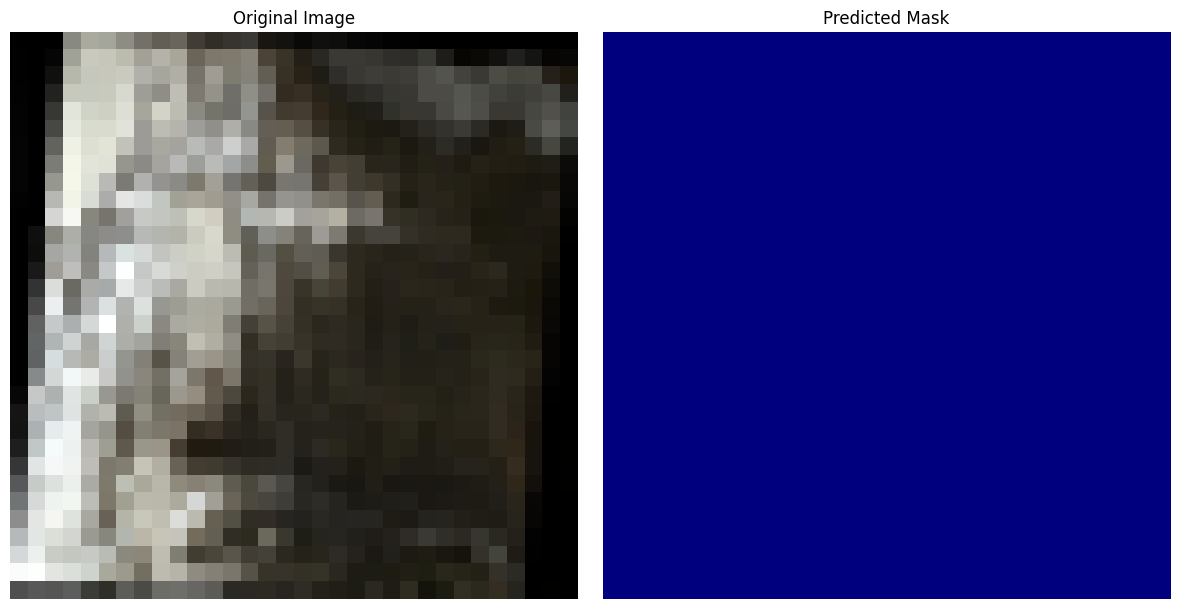

In [26]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def visualize_image_and_mask(image_path, predicted_mask, target_size):
    """Visualize the original image and its predicted mask side by side."""
    # Load the original image
    original_image = Image.open(image_path).convert("RGB")
    original_image = original_image.resize(target_size, Image.Resampling.LANCZOS)

    # Convert predicted mask to an image for visualization
    mask_image = Image.fromarray(predicted_mask.astype(np.uint8))
    mask_image = mask_image.resize(target_size, Image.Resampling.LANCZOS)

    # Create a side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')  # Hide axes

    axes[1].imshow(mask_image, cmap='jet')  # Use a color map for better visualization of the mask
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

# Usage example (after prediction):

# Visualize the image and its predicted mask
visualize_image_and_mask(image_path, predicted_mask, target_size)


**Without** **Augmentation**


Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3214 - loss: 0.7631 - mean_io_u_15: 0.4376 - val_accuracy: 0.4120 - val_loss: 0.5904 - val_mean_io_u_15: 0.5715 - learning_rate: 0.0010
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 709ms/step - accuracy: 0.5178 - loss: 0.5169 - mean_io_u_15: 0.4407 - val_accuracy: 0.4640 - val_loss: 0.5377 - val_mean_io_u_15: 0.5738 - learning_rate: 0.0010
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 672ms/step - accuracy: 0.5364 - loss: 0.4784 - mean_io_u_15: 0.4505 - val_accuracy: 0.4777 - val_loss: 0.5259 - val_mean_io_u_15: 0.5808 - learning_rate: 0.0010
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 712ms/step - accuracy: 0.5403 - loss: 0.4712 - mean_io_u_15: 0.4549 - val_accuracy: 0.4868 - val_loss: 0.5159 - val_mean_io_u_15: 0.6086 - learning_rate: 0.0010
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - accuracy: 0.5402 - loss: 0.4649 - mean_io_u_15: 0.4628 - val_accuracy: 0.4849 - val_loss: 0.5236 - val_mean_io_u_15: 0.4932 - learning_rate: 0.00

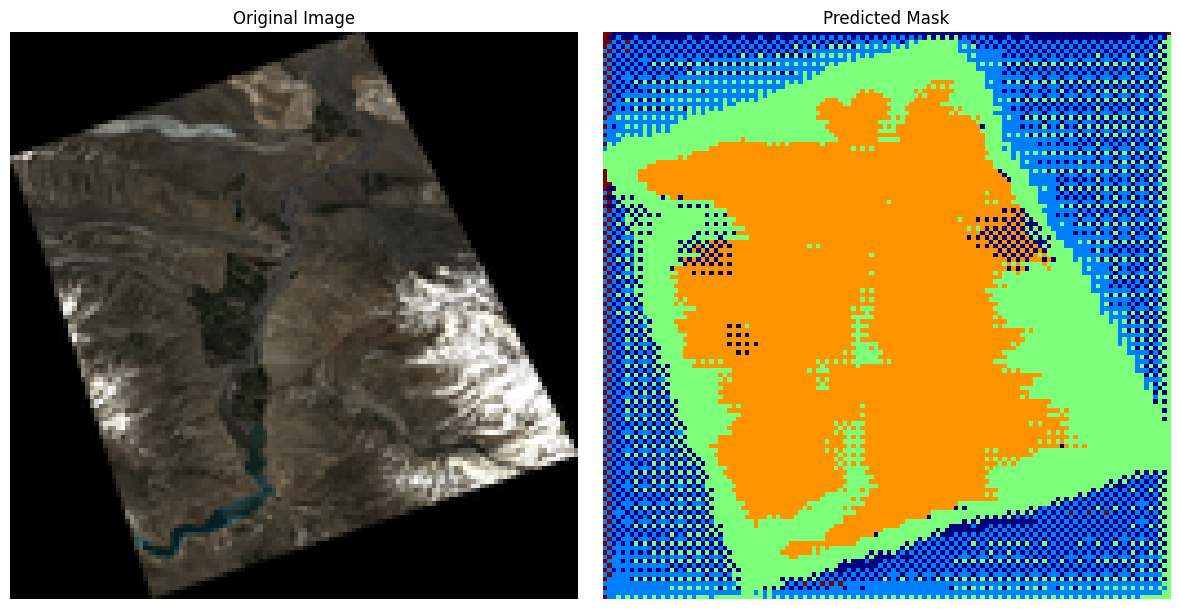

In [35]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.saving import register_keras_serializable

# Enable mixed precision training
mixed_precision.set_global_policy('mixed_float16')

def resize_image(image, target_size):
    """Resize the image to the target size using PIL."""
    return np.array(Image.fromarray(image).resize(target_size, Image.Resampling.LANCZOS))

class DataGenerator(Sequence):
    def __init__(self, image_files, mask_files, batch_size, image_folder, mask_folder, patch_size, num_classes=8, augment=False):
        self.image_files = image_files
        self.mask_files = mask_files
        self.batch_size = batch_size
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.augment = augment  # Augmentation flag (not used now)
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_files) // self.batch_size

    def __getitem__(self, index):
        batch_images = self.image_files[index * self.batch_size:(index + 1) * self.batch_size]
        batch_masks = self.mask_files[index * self.batch_size:(index + 1) * self.batch_size]

        images, masks = [], []
        for img_file, mask_file in zip(batch_images, batch_masks):
            # Load and preprocess image
            image = np.array(Image.open(os.path.join(self.image_folder, img_file)).convert("RGB"))
            image = resize_image(image, (self.patch_size, self.patch_size))  # Resize image

            # Load and preprocess mask
            mask = np.array(Image.open(os.path.join(self.mask_folder, mask_file)).convert("L"))
            mask = resize_image(mask, (self.patch_size, self.patch_size))  # Resize mask
            mask = one_hot_encode_mask(mask, num_classes=self.num_classes)

            images.append(image)
            masks.append(mask)

        images = np.array(images).astype(np.float32)
        masks = np.array(masks).astype(np.float32)

        return images, masks

    def on_epoch_end(self):
        combined = list(zip(self.image_files, self.mask_files))
        np.random.shuffle(combined)
        self.image_files, self.mask_files = zip(*combined)


def one_hot_encode_mask(mask, num_classes):
    """Convert a grayscale mask to a one-hot encoded format."""
    one_hot = np.zeros((mask.shape[0], mask.shape[1], num_classes), dtype=np.float32)
    for c in range(num_classes):
        one_hot[:, :, c] = (mask == c).astype(np.float32)
    return one_hot


# U-Net Model with VGG16 Encoder
def decoder_block(input_tensor, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)
    x = layers.Concatenate()([x, skip_features])
    x = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
    return x

def build_unet_vgg16(input_shape, num_classes):
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in vgg16.layers:
        layer.trainable = False  # Freeze the layers initially

    s1 = vgg16.get_layer('block1_conv2').output
    s2 = vgg16.get_layer('block2_conv2').output
    s3 = vgg16.get_layer('block3_conv3').output
    s4 = vgg16.get_layer('block4_conv3').output
    p4 = vgg16.get_layer('block5_conv3').output

    d1 = decoder_block(p4, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Add batch normalization after each convolution layer
    d4 = layers.BatchNormalization()(d4)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(d4)
    return Model(inputs=vgg16.input, outputs=outputs)


# Paths
image_folder = '/content/drive/MyDrive/originals'
mask_folder = '/content/drive/MyDrive/masks'
patch_size = 128

# File Lists
image_files = sorted(os.listdir(image_folder))
mask_files = sorted(os.listdir(mask_folder))

# Train-Test Split
train_images, val_images, train_masks, val_masks = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

# Data Generators without Augmentation
batch_size = 4
train_generator = DataGenerator(train_images, train_masks, batch_size, image_folder, mask_folder, patch_size, augment=False)
val_generator = DataGenerator(val_images, val_masks, batch_size, image_folder, mask_folder, patch_size, augment=False)

# Build Model
input_shape = (patch_size, patch_size, 3)
num_classes = 8
model = build_unet_vgg16(input_shape, num_classes)

# Compile Model with Dice Loss
@register_keras_serializable()
def dice_loss(y_true, y_pred):
    smooth = 1e-5
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return 1 - (2. * intersection + smooth) / (union + smooth)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=dice_loss,
    metrics=['accuracy', MeanIoU(num_classes=num_classes)]
)

# Callbacks
checkpoint = ModelCheckpoint('unet_model_best.keras', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train Model with additional callbacks
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=500,
        callbacks=[checkpoint, early_stopping, lr_scheduler]
    )

# Save Final Model
model.save('final_unet_model.keras')


# Usage example for prediction and visualization
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def visualize_image_and_mask(image_path, predicted_mask, target_size):
    """Visualize the original image and its predicted mask side by side."""
    # Load the original image
    original_image = Image.open(image_path).convert("RGB")
    original_image = original_image.resize(target_size, Image.Resampling.LANCZOS)

    # Convert predicted mask to an image for visualization
    mask_image = Image.fromarray(predicted_mask.astype(np.uint8))
    mask_image = mask_image.resize(target_size, Image.Resampling.LANCZOS)

    # Create a side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')  # Hide axes

    axes[1].imshow(mask_image, cmap='jet')  # Use a color map for better visualization of the mask
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

# Load the trained model
model = load_trained_model('final_unet_model.keras')

# Predict the mask for an image
image_path = '/content/Shisper_2023_June_5.jpg'  # Replace with actual image path
predicted_mask = predict_mask(model, image_path, target_size=(patch_size, patch_size))

# Visualize the image and its predicted mask
visualize_image_and_mask(image_path, predicted_mask, target_size=(patch_size, patch_size))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


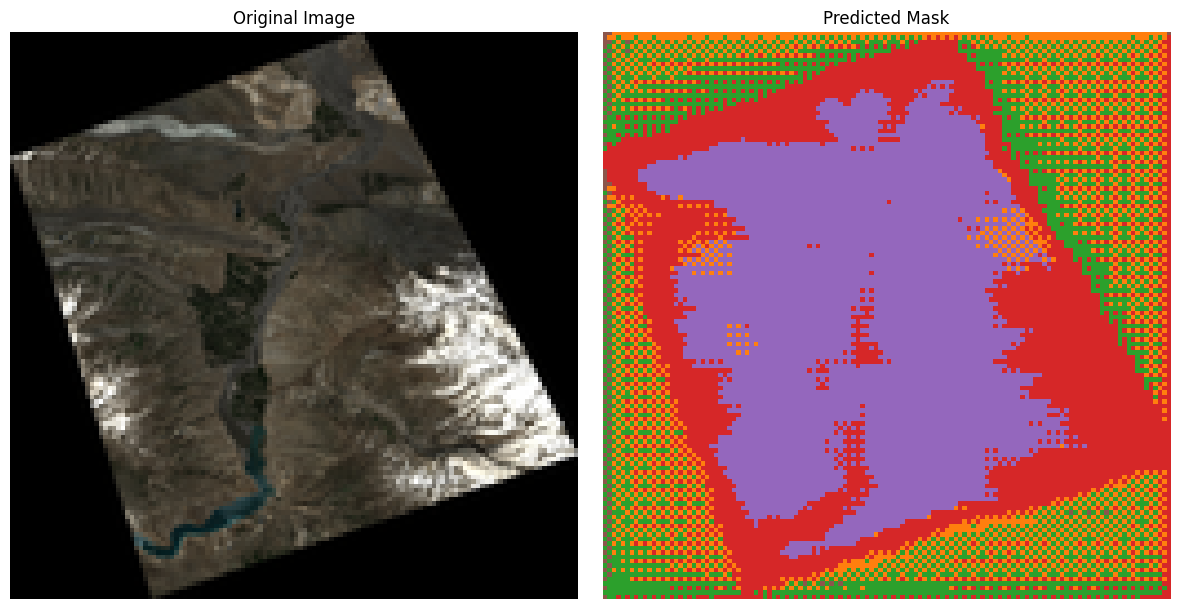

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf

def visualize_image_and_mask(image_path, predicted_mask, target_size, num_classes):
    """Visualize the original image and its predicted mask with colored classes side by side."""
    # Load the original image
    original_image = Image.open(image_path).convert("RGB")
    original_image = original_image.resize(target_size, Image.Resampling.LANCZOS)

    # Apply color to the predicted mask
    # Create a colormap: each class will be represented by a unique color
    colormap = plt.get_cmap("tab10")  # You can choose other colormaps like "viridis", "plasma", etc.
    colored_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)

    for class_idx in range(num_classes):
        # Create a binary mask for each class
        # Modified: Access the predicted_mask directly using class_idx
        class_mask = (predicted_mask == class_idx).astype(np.uint8)
        colored_mask[class_mask == 1] = np.array(colormap(class_idx)[:3]) * 255  # Map the class index to a color

    # Create a side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')  # Hide axes

    axes[1].imshow(colored_mask)  # Display the colored mask
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

# Example function to get the predicted mask from the model (assuming it's a segmentation problem)
def predict_mask(model, image_path, target_size):
    """Predict the mask for a given image using the trained model."""
    # Load and preprocess image
    image = np.array(Image.open(image_path).convert("RGB"))
    image = resize_image(image, target_size)  # Resize image
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict mask
    predicted_mask = model.predict(image)

    # Convert from one-hot encoding to class map
    predicted_mask = np.argmax(predicted_mask, axis=-1)  # Convert the one-hot encoded output to a single class label per pixel
    predicted_mask = np.squeeze(predicted_mask, axis=0)  # Remove batch dimension

    return predicted_mask

# Example usage
image_path = '/content/Shisper_2023_June_5.jpg'  # Replace with your actual image path
predicted_mask = predict_mask(model, image_path, target_size=(patch_size, patch_size))

# Visualize the image and its predicted mask
visualize_image_and_mask(image_path, predicted_mask, target_size=(patch_size, patch_size), num_classes=8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


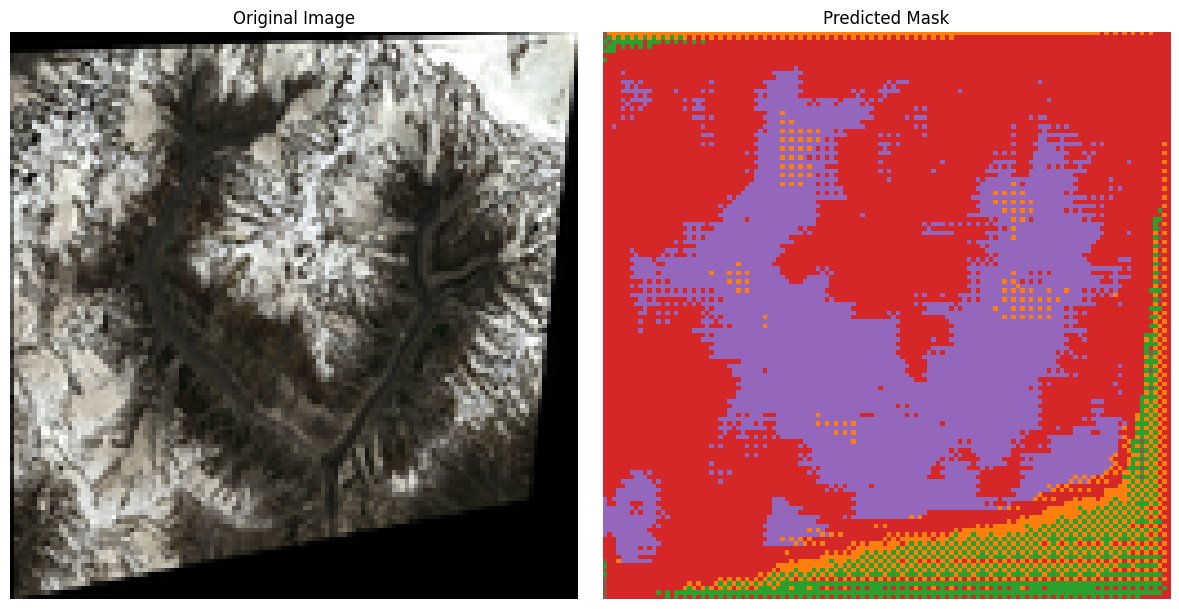

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf

def visualize_image_and_mask(image_path, predicted_mask, target_size, num_classes):
    """Visualize the original image and its predicted mask with colored classes side by side."""
    # Load the original image
    original_image = Image.open(image_path).convert("RGB")
    original_image = original_image.resize(target_size, Image.Resampling.LANCZOS)

    # Apply color to the predicted mask
    # Create a colormap: each class will be represented by a unique color
    colormap = plt.get_cmap("tab10")  # You can choose other colormaps like "viridis", "plasma", etc.
    colored_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)

    for class_idx in range(num_classes):
        # Create a binary mask for each class
        # Modified: Access the predicted_mask directly using class_idx
        class_mask = (predicted_mask == class_idx).astype(np.uint8)
        colored_mask[class_mask == 1] = np.array(colormap(class_idx)[:3]) * 255  # Map the class index to a color

    # Create a side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')  # Hide axes

    axes[1].imshow(colored_mask)  # Display the colored mask
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

# Example function to get the predicted mask from the model (assuming it's a segmentation problem)
def predict_mask(model, image_path, target_size):
    """Predict the mask for a given image using the trained model."""
    # Load and preprocess image
    image = np.array(Image.open(image_path).convert("RGB"))
    image = resize_image(image, target_size)  # Resize image
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict mask
    predicted_mask = model.predict(image)

    # Convert from one-hot encoding to class map
    predicted_mask = np.argmax(predicted_mask, axis=-1)  # Convert the one-hot encoded output to a single class label per pixel
    predicted_mask = np.squeeze(predicted_mask, axis=0)  # Remove batch dimension

    return predicted_mask

# Example usage
image_path = '/content/Shisper_2023_June_1.jpg'  # Replace with your actual image path
predicted_mask = predict_mask(model, image_path, target_size=(patch_size, patch_size))

# Visualize the image and its predicted mask
visualize_image_and_mask(image_path, predicted_mask, target_size=(patch_size, patch_size), num_classes=8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


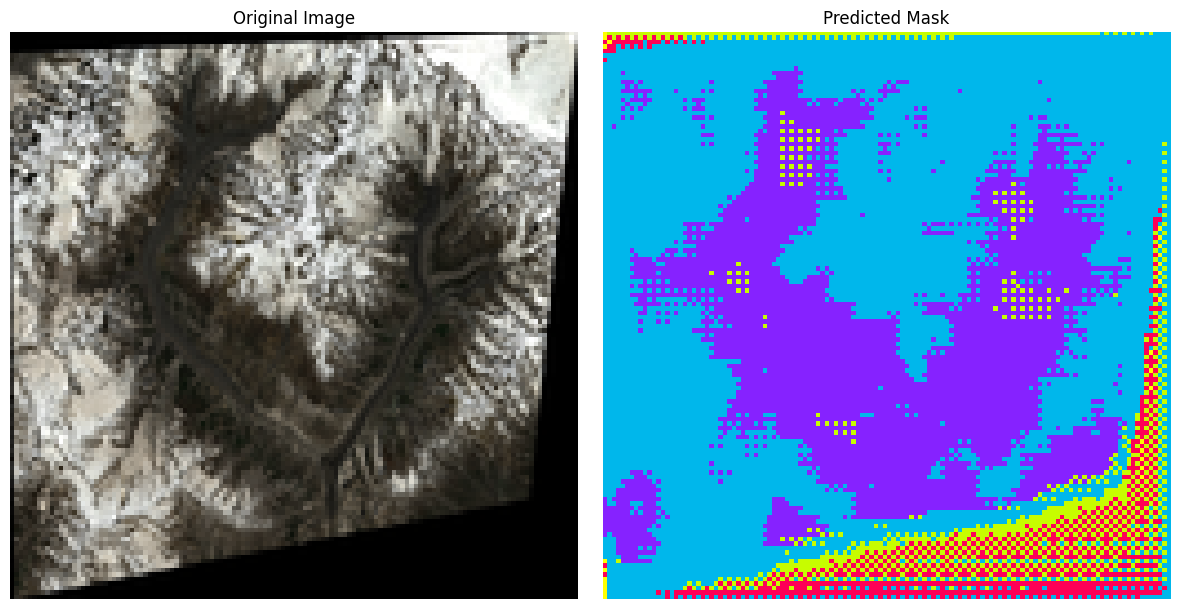

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf

# Define the color map for classes
color_map = {
    0: (255, 255, 0),  # Background
    1: (199, 252, 0),  # Glacier
    2: (254, 0, 86),   # House_Building
    3: (0, 183, 235),  # Ice
    4: (134, 34, 255), # Land
    5: (255, 255, 0),  # Undefined
    6: (0, 255, 206),  # Vegetation
    7: (255, 128, 0),  # Water
}

def visualize_image_and_mask(image_path, predicted_mask, target_size, num_classes):
    """Visualize the original image and its predicted mask with colored classes side by side."""
    # Load the original image
    original_image = Image.open(image_path).convert("RGB")
    original_image = original_image.resize(target_size, Image.Resampling.LANCZOS)

    # Apply color to the predicted mask based on the color map
    colored_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)

    for class_idx in range(num_classes):
        # Create a binary mask for each class
        class_mask = (predicted_mask == class_idx).astype(np.uint8)
        colored_mask[class_mask == 1] = color_map[class_idx]  # Map the class index to a color from the color_map

    # Create a side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')  # Hide axes

    axes[1].imshow(colored_mask)  # Display the colored mask
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

# Example function to get the predicted mask from the model (assuming it's a segmentation problem)
def predict_mask(model, image_path, target_size):
    """Predict the mask for a given image using the trained model."""
    # Load and preprocess image
    image = np.array(Image.open(image_path).convert("RGB"))
    image = resize_image(image, target_size)  # Resize image
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict mask
    predicted_mask = model.predict(image)

    # Convert from one-hot encoding to class map
    predicted_mask = np.argmax(predicted_mask, axis=-1)  # Convert the one-hot encoded output to a single class label per pixel
    predicted_mask = np.squeeze(predicted_mask, axis=0)  # Remove batch dimension

    return predicted_mask

# Example usage
image_path = '/content/Shisper_2023_June_1.jpg'  # Replace with your actual image path
predicted_mask = predict_mask(model, image_path, target_size=(patch_size, patch_size))

# Visualize the image and its predicted mask
visualize_image_and_mask(image_path, predicted_mask, target_size=(patch_size, patch_size), num_classes=8)
